In [0]:
import numpy as np
import pandas as pd
import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import  scale
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error

In [0]:
df = pd.read_csv('../data/COKE.csv', parse_dates=True)
df['Date'] = pd.to_datetime(df['Date'])

In [3]:
df.isnull().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [4]:
#add some time based features
df['year'] = df['Date'].dt.year
df['weekofyear'] = df['Date'].dt.weekofyear

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 9 columns):
Date          503 non-null datetime64[ns]
Open          503 non-null float64
High          503 non-null float64
Low           503 non-null float64
Close         503 non-null float64
Adj Close     503 non-null float64
Volume        503 non-null int64
year          503 non-null int64
weekofyear    503 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 35.4 KB
None


,Date,Open,High,Low,Close,Adj Close,Volume,year,weekofyear
0,2017-09-14,210.990005,210.990005,207.369995,208.990005,206.920776,32800,2017,37
1,2017-09-15,208.050003,209.949997,206.809998,208.889999,206.821762,74700,2017,37
2,2017-09-18,208.410004,211.970001,208.410004,210.889999,208.801941,41200,2017,38
3,2017-09-19,211.179993,214.630005,209.289993,211.389999,209.296997,33300,2017,38
4,2017-09-20,210.770004,212.139999,208.000000,209.580002,207.504929,31400,2017,38


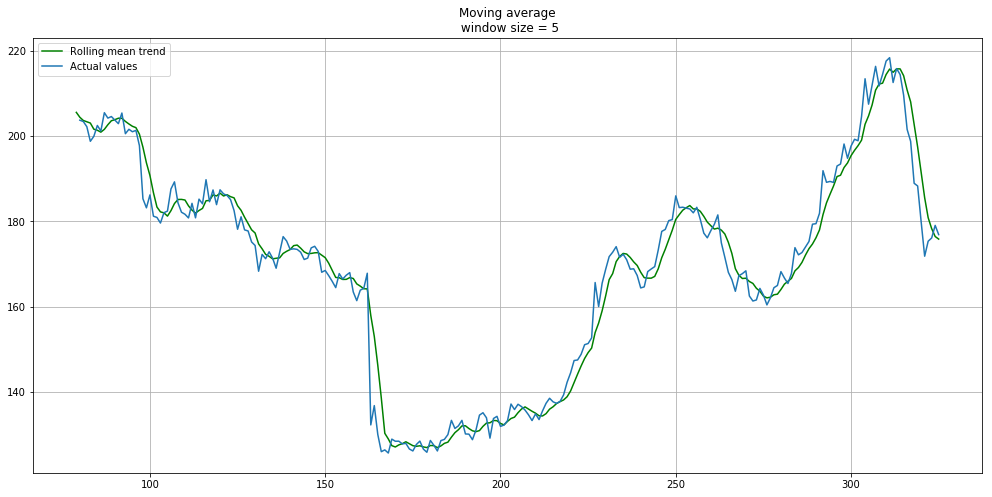

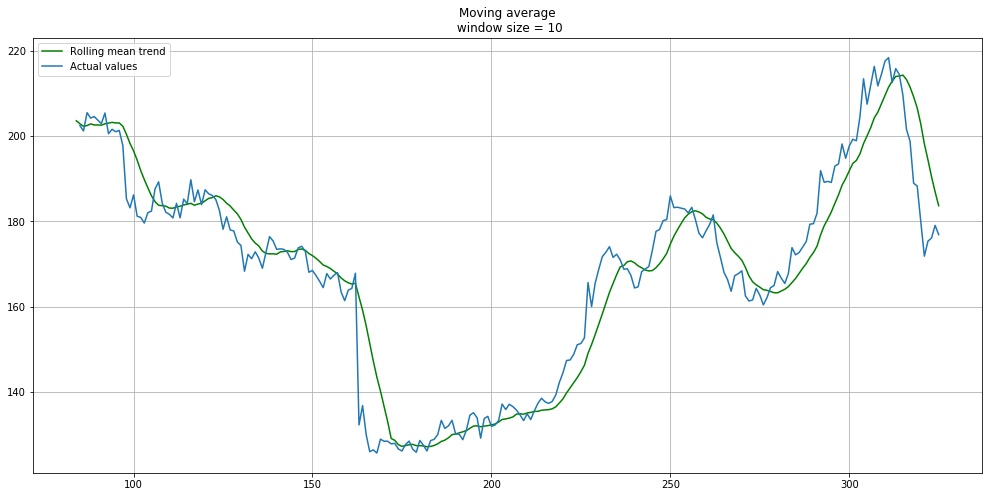

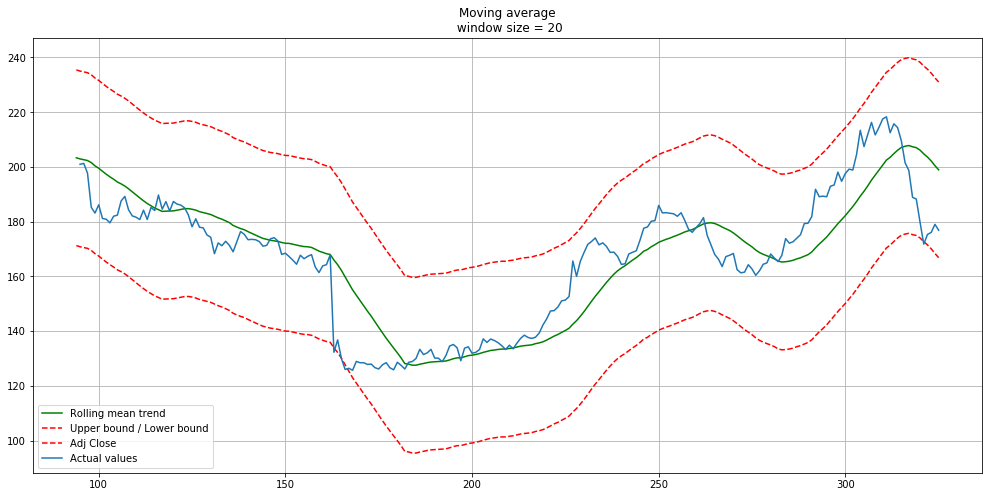

In [5]:
df_year = df[df['year'] == 2018]
df_year.set_index('Date')

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(df_year['Adj Close'], 5)

#Smooth by the previous month (30 days)
plot_moving_average(df_year['Adj Close'], 10)

#Smooth by previous quarter (90 days)
plot_moving_average(df_year['Adj Close'], 20, plot_intervals=True)

In [0]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=10).mean()

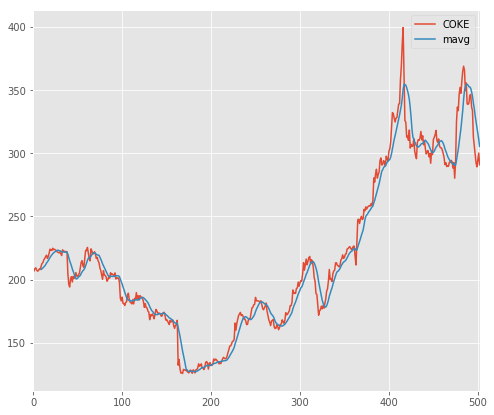

In [7]:
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
plt.style.use('ggplot')

close_px.plot(label='COKE')
mavg.plot(label='mavg')
plt.legend();

In [0]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [0]:
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2048)

In [11]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [12]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [13]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

print("The linear regression confidence is ",confidencereg)
print("The quadratic regression 2 confidence is ",confidencepoly2)
print("The quadratic regression 3 confidence is ",confidencepoly3)
print("The knn regression confidence is ",confidenceknn)

The linear regression confidence is  0.9220051062878897
The quadratic regression 2 confidence is  0.9239316059367837
The quadratic regression 3 confidence is  0.9171402664559315
The knn regression confidence is  0.8662405259964996


In [14]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

print("The linear regression confidence is ",confidencereg)
print("The quadratic regression 2 confidence is ",confidencepoly2)
print("The quadratic regression 3 confidence is ",confidencepoly3)
print("The knn regression confidence is ",confidenceknn)

The linear regression confidence is  0.9220051062878897
The quadratic regression 2 confidence is  0.9239316059367837
The quadratic regression 3 confidence is  0.9171402664559315
The knn regression confidence is  0.8662405259964996


In [15]:
# Printing the forecast
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan
print(forecast_set, confidencereg, forecast_out)

[296.02503667 289.15368073 286.98701295 293.90811056 298.38971593
 289.9611708 ] 0.9220051062878897 6


In [24]:
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change,label,Forecast
0,206.920776,32800,1.732145,-0.947912,207.227676,NaN
1,206.821762,74700,1.503183,0.403747,208.534637,NaN
2,208.801941,41200,1.688082,1.189960,208.168304,NaN
3,209.296997,33300,2.526142,0.099444,210.940552,NaN
4,207.504929,31400,1.975379,-0.564597,212.881149,NaN


In [27]:
df.iloc[-1]['Date']

Timestamp('2019-09-13 00:00:00')

In [0]:
last_date = df.iloc[-150]['Date']
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

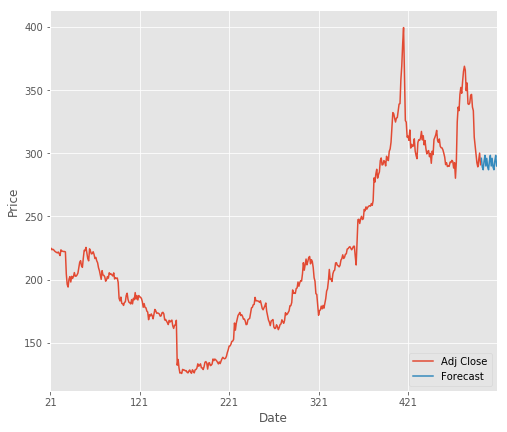

In [33]:
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [0]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(df['Adj Close'], lags=30)

# Take the first difference to remove to make the process stationary
data_diff = df['Adj Close'] - df['Adj Close'].shift(1)

tsplot(df['Adj Close'][1:], lags=30)